In [1]:
import pandas as pd
import numpy as np
import plotly_express as px
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, PULP_CBC_CMD
from datetime import datetime
import csv
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [2]:
source_dir = os.path.join("data", "raw")

In [3]:
df_16_22 = pd.read_csv(os.path.join(source_dir, "cleaned_merged_gw_16-22.csv"))
df_23_24 = pd.read_csv(os.path.join(source_dir, "cleaned_merged_gw_23-24.csv"))
df_24_25_initial = pd.read_csv(os.path.join(source_dir, "cleaned_players_24-25_11082024.csv"))

/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_3319/2612523512.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_16_22 = pd.read_csv(os.path.join(source_dir, "cleaned_merged_gw_16-22.csv"))


In [4]:
df_players = pd.read_csv(os.path.join(source_dir, "player_idlist.csv"))
df_teams = pd.read_csv(os.path.join(source_dir, "teams.csv"))

In [5]:
df_24_25_initial["name"] = df_24_25_initial['first_name'] + " " + df_24_25_initial["second_name"]
df_24_25_initial.drop(['first_name', 'second_name'], axis=1, inplace=True)

# *Inspect Data*

In [6]:
df_16_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96169 entries, 0 to 96168
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_x           96169 non-null  object 
 1   name               96169 non-null  object 
 2   position           96169 non-null  object 
 3   team_x             76317 non-null  object 
 4   assists            96169 non-null  int64  
 5   bonus              96169 non-null  int64  
 6   bps                96169 non-null  int64  
 7   clean_sheets       96169 non-null  int64  
 8   creativity         96169 non-null  float64
 9   element            96169 non-null  int64  
 10  fixture            96169 non-null  int64  
 11  goals_conceded     96169 non-null  int64  
 12  goals_scored       96169 non-null  int64  
 13  ict_index          96169 non-null  float64
 14  influence          96169 non-null  float64
 15  kickoff_time       96169 non-null  object 
 16  minutes            961

In [7]:
df_16_22.head()

,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,...,2.0,0.0,0,0,0,0,55,False,0,1
1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,142,...,1.0,0.0,1,0,0,0,60,True,0,1
2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,16,...,3.0,23.0,2,0,0,0,80,True,0,1
3,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,...,1.0,0.0,0,0,0,0,50,False,0,1
4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,...,1.0,0.0,1,0,0,0,45,True,1,1


In [8]:
df_23_24.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Femi Seriki,DEF,Sheffield Utd,0.5,0,0,0,0,0.0,653,...,0,0.0,0,0,0,0,40,True,0,1
1,Jack Hinshelwood,MID,Brighton,1.5,0,0,0,0,0.0,621,...,4,0.0,0,0,0,0,45,True,0,1
2,Jadon Sancho,MID,Man Utd,3.0,0,0,4,0,11.3,397,...,1,8.0,1,0,0,0,70,True,0,1
3,Rhys Norrington-Davies,DEF,Sheffield Utd,0.1,0,0,0,0,0.0,487,...,0,0.0,0,0,0,0,40,True,0,1
4,Vitaly Janelt,MID,Brentford,2.1,0,0,6,0,11.5,105,...,2,17.0,2,0,0,0,55,True,0,1


In [9]:
df_teams.head()

,code,draw,form,id,loss,name,played,points,position,short_name,...,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,NaN,1,0,Arsenal,0,0,0,ARS,...,NaN,False,0,1350,1380,1370,1370,1330,1390,1
1,7,0,NaN,2,0,Aston Villa,0,0,0,AVL,...,NaN,False,0,1120,1245,1110,1140,1130,1350,2
2,91,0,NaN,3,0,Bournemouth,0,0,0,BOU,...,NaN,False,0,1100,1100,1075,1100,1130,1105,127
3,94,0,NaN,4,0,Brentford,0,0,0,BRE,...,NaN,False,0,1100,1100,1105,1095,1100,1110,130
4,36,0,NaN,5,0,Brighton,0,0,0,BHA,...,NaN,False,0,1100,1100,1100,1105,1100,1100,131


In [10]:
df_24_25_initial

,goals_scored,assists,total_points,minutes,goals_conceded,creativity,influence,threat,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent,now_cost,element_type,name
0,1,3,24,290,2,88.8,82.8,85.0,0,67,25.5,1,1,0,0.1,55,MID,Fábio Ferreira Vieira
1,4,7,85,1470,11,403.0,364.8,756.0,10,271,152.7,11,0,6,1.5,70,FWD,Gabriel Fernando de Jesus
2,3,1,149,3042,26,121.9,675.8,379.0,8,676,117.9,16,0,4,11.9,60,DEF,Gabriel dos Santos Magalhães
3,13,10,180,2627,22,613.4,763.2,1027.0,15,515,240.2,16,0,11,14.2,80,FWD,Kai Havertz
4,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.3,40,GK,Karl Hein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.2,55,MID,Rodrigo Martins Gomes
580,0,0,13,819,18,27.1,173.8,2.0,0,124,20.3,0,0,1,0.2,45,DEF,Santiago Bueno
581,4,7,99,1737,27,795.3,469.2,418.0,8,358,168.4,6,0,5,0.3,55,MID,Pablo Sarabia
582,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.2,55,FWD,Jørgen Strand Larsen


In [11]:
df_players.head()

,first_name,second_name,id
0,Fábio,Ferreira Vieira,1
1,Gabriel,Fernando de Jesus,2
2,Gabriel,dos Santos Magalhães,3
3,Kai,Havertz,4
4,Karl,Hein,5


# *Clean Data*

### Clean initial 24-25 season data


In [12]:
df_24_25_initial['name'].value_counts()

name
Fábio Ferreira Vieira    1
Leny Yoro                1
Tom Heaton               1
Rasmus Højlund           1
Victor Lindelöf          1
                        ..
Naouirou Ahamada         1
Joachim Andersen         1
Jordan Ayew              1
Cheick Doucouré          1
Toti António Gomes       1
Name: count, Length: 584, dtype: int64

In [13]:
# drop all players with less than 90 matches
df_24_25_initial = df_24_25_initial.drop(df_24_25_initial[df_24_25_initial['minutes'] <= 90].index)

In [14]:
# add year
df_24_25_initial['year'] = 2024

In [15]:
# add season col
df_24_25_initial["season_x"] = "2024-25"

In [16]:
# initialize team col
#df_24_25_initial['team'] = ''

# Ensure df_23_24 has unique names by dropping duplicates based on the 'name' column
df_23_24_unique = df_23_24[['name', 'team']].drop_duplicates(subset='name')

# Now, merge the cleaned df_23_24_unique with df_24_25_initial
df_24_25_initial = df_24_25_initial.merge(df_23_24_unique, how='left', on='name')

df_24_25_initial.head()

,goals_scored,assists,total_points,minutes,goals_conceded,creativity,influence,threat,bonus,bps,...,clean_sheets,red_cards,yellow_cards,selected_by_percent,now_cost,element_type,name,year,season_x,team
0,1,3,24,290,2,88.8,82.8,85.0,0,67,...,1,1,0,0.1,55,MID,Fábio Ferreira Vieira,2024,2024-25,Arsenal
1,4,7,85,1470,11,403.0,364.8,756.0,10,271,...,11,0,6,1.5,70,FWD,Gabriel Fernando de Jesus,2024,2024-25,Arsenal
2,3,1,149,3042,26,121.9,675.8,379.0,8,676,...,16,0,4,11.9,60,DEF,Gabriel dos Santos Magalhães,2024,2024-25,Arsenal
3,13,10,180,2627,22,613.4,763.2,1027.0,15,515,...,16,0,11,14.2,80,FWD,Kai Havertz,2024,2024-25,Arsenal
4,0,2,44,913,11,187.8,165.4,16.0,1,182,...,4,0,1,0.3,50,MID,Jorge Luiz Frello Filho,2024,2024-25,Arsenal


In [17]:
# approximate number of games
df_24_25_initial['approx_games_played'] = df_24_25_initial['minutes'] / 90

In [18]:
# divide metrics by number of games 
divisor_column = 'approx_games_played'  # Replace with the actual column name

# Select numeric columns, excluding the 'now_cost' column
integer_columns = df_24_25_initial.select_dtypes(include=['int', 'float']).columns
integer_columns = integer_columns.difference(['now_cost'])

# Divide all integer columns by the specified divisor column
df_24_25_initial[integer_columns] = df_24_25_initial[integer_columns].div(df_24_25_initial[divisor_column], axis=0)

In [19]:
df_24_25_initial.rename(columns={'element_type': 'position'}, inplace=True)

### Join data

In [20]:
df_23_24["season_x"] = "2023-24"
df_23_24.rename(columns={"team_x": "team"}, inplace=True)
df_16_22.rename(columns={"team_x": "team"}, inplace=True)

In [21]:
# combine dfs
df = pd.concat([df_16_22, df_23_24, df_24_25_initial], ignore_index=True)

df.rename(columns={
    "team_x": "team",
    "season_x": "season",
}, inplace=True)

# Step 2: Set 'new_value' to 'now_cost' where available
df['new_value'] = df['now_cost']

# Step 3: For players who do not have 'now_cost', fill 'new_value' with their most recent 'value'
df['new_value'] = df.groupby('name')['new_value'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# Step 4: For any remaining NaNs (players without any past or present cost), fill with 0 or another placeholder value if needed
df['new_value'].fillna(0, inplace=True)

# Step 5: Drop the 'now_cost' column as it's no longer needed
df = df.drop(columns=['now_cost'])

df

/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_3319/2491521654.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['new_value'] = df.groupby('name')['new_value'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_3319/2491521654.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['new_value'].fillna(0, inplace=True)


,season,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,...,xP,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,starts,selected_by_percent,year,approx_games_played,new_value
0,2016-17,Aaron Cresswell,DEF,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,454.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0
1,2016-17,Aaron Lennon,MID,NaN,0.000000,0.000000,6.000000,0.000000,0.300000,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2016-17,Aaron Ramsey,MID,NaN,0.000000,0.000000,5.000000,0.000000,4.900000,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2016-17,Abdoulaye Doucouré,MID,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,482.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0
4,2016-17,Adam Forshaw,MID,NaN,0.000000,0.000000,3.000000,0.000000,1.300000,286.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126263,2024-25,Nélson Cabral Semedo,DEF,Wolves,0.058366,0.000000,13.278210,0.145914,11.547665,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,59.066148,1.0,45.0
126264,2024-25,Pedro Lomba Neto,MID,Wolves,0.653034,0.474934,18.403694,0.178100,35.572559,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.071240,120.158311,1.0,65.0
126265,2024-25,Santiago Bueno,DEF,Wolves,0.000000,0.000000,13.626374,0.000000,2.978022,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.021978,222.417582,1.0,45.0
126266,2024-25,Pablo Sarabia,MID,Wolves,0.362694,0.414508,18.549223,0.310881,41.207254,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.015544,104.870466,1.0,55.0


### Drop non-mutual columns that can't be used

In [22]:
df['played'] = df['minutes'] > 5

df = df.drop([
    "xP",
    "expected_assists",
    "expected_goal_involvements",
    "expected_goals",
    "expected_goals_conceded",
    "starts",
    "opp_team_name",
    'approx_games_played',
    'element',
    'fixture',
    #"team",

], axis=1)

### Add player IDs

In [23]:
# add player_ids to the main dataset based on first and second name

df_players["name"] = df_players["first_name"] + " " + df_players["second_name"]

df = pd.merge(df, df_players.drop(["first_name", "second_name"], axis=1), how="left", on=["name"])

df.rename(columns={'id': 'player_id'}, inplace=True)

df

,season,name,position,team,assists,bonus,bps,clean_sheets,creativity,goals_conceded,...,transfers_out,value,was_home,yellow_cards,GW,selected_by_percent,year,new_value,played,player_id
0,2016-17,Aaron Cresswell,DEF,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,55.0,False,0.000000,1.0,NaN,NaN,40.0,False,517.0
1,2016-17,Aaron Lennon,MID,NaN,0.000000,0.000000,6.000000,0.000000,0.300000,0.000000,...,0.0,60.0,True,0.000000,1.0,NaN,NaN,0.0,True,NaN
2,2016-17,Aaron Ramsey,MID,NaN,0.000000,0.000000,5.000000,0.000000,4.900000,3.000000,...,0.0,80.0,True,0.000000,1.0,NaN,NaN,0.0,True,NaN
3,2016-17,Abdoulaye Doucouré,MID,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,50.0,False,0.000000,1.0,NaN,NaN,55.0,False,217.0
4,2016-17,Adam Forshaw,MID,NaN,0.000000,0.000000,3.000000,0.000000,1.300000,1.000000,...,0.0,45.0,True,1.000000,1.0,NaN,NaN,0.0,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126263,2024-25,Nélson Cabral Semedo,DEF,Wolves,0.058366,0.000000,13.278210,0.145914,11.547665,1.809339,...,NaN,NaN,NaN,0.291829,NaN,0.000000,59.066148,45.0,True,559.0
126264,2024-25,Pedro Lomba Neto,MID,Wolves,0.653034,0.474934,18.403694,0.178100,35.572559,1.602902,...,NaN,NaN,NaN,0.237467,NaN,0.071240,120.158311,65.0,True,560.0
126265,2024-25,Santiago Bueno,DEF,Wolves,0.000000,0.000000,13.626374,0.000000,2.978022,1.978022,...,NaN,NaN,NaN,0.109890,NaN,0.021978,222.417582,45.0,True,564.0
126266,2024-25,Pablo Sarabia,MID,Wolves,0.362694,0.414508,18.549223,0.310881,41.207254,1.398964,...,NaN,NaN,NaN,0.259067,NaN,0.015544,104.870466,55.0,True,565.0


In [24]:
# players who have no ID means they're not available for picking the current season (player IDs come from this season's players) - thus we drop them
df = df.dropna(subset='player_id', axis=0)

### Map players to teams

In [25]:
df.columns

Index(['season', 'name', 'position', 'team', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'team_a_score', 'team_h_score', 'threat',
       'total_points', 'transfers_balance', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'yellow_cards', 'GW', 'selected_by_percent',
       'year', 'new_value', 'played', 'player_id'],
      dtype='object')

In [26]:
# create a dictionary mapping player_id to team
player_team_mapping = df[df['team'].notna()][['player_id', 'team']].set_index('player_id')['team'].to_dict()

# fill in NaN values in 'team_x' based on player_id mapping
for index, row in df.iterrows():
    if pd.isnull(row['team']):
        player_id = row['player_id']
        if player_id in player_team_mapping:
            df.at[index, 'team'] = player_team_mapping[player_id]

In [27]:
# create a dictionary to map teams to codes
team_codes = {}
teams = df['team'].dropna().unique()
teams.sort()  # Sort teams alphabetically

# Assign codes to teams
for i, team in enumerate(teams):
    team_codes[team] = i + 1  # Start codes from 1

# Create a new column 'team_code' in the DataFrame
df['team_code'] = df['team'].map(team_codes)

# Display team names and their codes
for team, code in team_codes.items():
    print(f"Team: {team}, Code: {code}")

Team: Arsenal, Code: 1
Team: Aston Villa, Code: 2
Team: Bournemouth, Code: 3
Team: Brentford, Code: 4
Team: Brighton, Code: 5
Team: Burnley, Code: 6
Team: Chelsea, Code: 7
Team: Crystal Palace, Code: 8
Team: Everton, Code: 9
Team: Fulham, Code: 10
Team: Leeds, Code: 11
Team: Leicester, Code: 12
Team: Liverpool, Code: 13
Team: Luton, Code: 14
Team: Man City, Code: 15
Team: Man Utd, Code: 16
Team: Newcastle, Code: 17
Team: Norwich, Code: 18
Team: Nott'm Forest, Code: 19
Team: Sheffield Utd, Code: 20
Team: Southampton, Code: 21
Team: Spurs, Code: 22
Team: Watford, Code: 23
Team: West Brom, Code: 24
Team: West Ham, Code: 25
Team: Wolves, Code: 26


/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_3319/1570411044.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['team_code'] = df['team'].map(team_codes)


### Add current player costs

In [28]:
new_player_costs = df_24_25_initial[['name', 'now_cost']]

new_player_costs

,name,now_cost
0,Fábio Ferreira Vieira,55
1,Gabriel Fernando de Jesus,70
2,Gabriel dos Santos Magalhães,60
3,Kai Havertz,80
4,Jorge Luiz Frello Filho,50
...,...,...
369,Nélson Cabral Semedo,45
370,Pedro Lomba Neto,65
371,Santiago Bueno,45
372,Pablo Sarabia,55


In [29]:
df.columns

Index(['season', 'name', 'position', 'team', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'team_a_score', 'team_h_score', 'threat',
       'total_points', 'transfers_balance', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'yellow_cards', 'GW', 'selected_by_percent',
       'year', 'new_value', 'played', 'player_id', 'team_code'],
      dtype='object')

In [30]:
df_24_25_initial

,goals_scored,assists,total_points,minutes,goals_conceded,creativity,influence,threat,bonus,bps,...,red_cards,yellow_cards,selected_by_percent,now_cost,position,name,year,season_x,team,approx_games_played
0,0.310345,0.931034,7.448276,90.0,0.620690,27.558621,25.696552,26.379310,0.000000,20.793103,...,0.310345,0.000000,0.031034,55,MID,Fábio Ferreira Vieira,628.137931,2024-25,Arsenal,1.0
1,0.244898,0.428571,5.204082,90.0,0.673469,24.673469,22.334694,46.285714,0.612245,16.591837,...,0.000000,0.367347,0.091837,70,FWD,Gabriel Fernando de Jesus,123.918367,2024-25,Arsenal,1.0
2,0.088757,0.029586,4.408284,90.0,0.769231,3.606509,19.994083,11.213018,0.236686,20.000000,...,0.000000,0.118343,0.352071,60,DEF,Gabriel dos Santos Magalhães,59.881657,2024-25,Arsenal,1.0
3,0.445375,0.342596,6.166730,90.0,0.753711,21.014846,26.146936,35.184621,0.513894,17.643700,...,0.000000,0.376856,0.486486,80,FWD,Kai Havertz,69.341454,2024-25,Arsenal,1.0
4,0.000000,0.197152,4.337349,90.0,1.084337,18.512596,16.304491,1.577218,0.098576,17.940854,...,0.000000,0.098576,0.029573,50,MID,Jorge Luiz Frello Filho,199.518072,2024-25,Arsenal,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,0.000000,0.058366,1.838521,90.0,1.809339,11.547665,14.848249,4.815175,0.000000,13.278210,...,0.029183,0.291829,0.000000,45,DEF,Nélson Cabral Semedo,59.066148,2024-25,Wolves,1.0
370,0.118734,0.653034,5.105541,90.0,1.602902,35.572559,22.048813,23.093668,0.474934,18.403694,...,0.000000,0.237467,0.071240,65,MID,Pedro Lomba Neto,120.158311,2024-25,Wolves,1.0
371,0.000000,0.000000,1.428571,90.0,1.978022,2.978022,19.098901,0.219780,0.000000,13.626374,...,0.000000,0.109890,0.021978,45,DEF,Santiago Bueno,222.417582,2024-25,Wolves,1.0
372,0.207254,0.362694,5.129534,90.0,1.398964,41.207254,24.310881,21.658031,0.414508,18.549223,...,0.000000,0.259067,0.015544,55,MID,Pablo Sarabia,104.870466,2024-25,Wolves,1.0


In [31]:
print(df_24_25_initial.columns)

Index(['goals_scored', 'assists', 'total_points', 'minutes', 'goals_conceded',
       'creativity', 'influence', 'threat', 'bonus', 'bps', 'ict_index',
       'clean_sheets', 'red_cards', 'yellow_cards', 'selected_by_percent',
       'now_cost', 'position', 'name', 'year', 'season_x', 'team',
       'approx_games_played'],
      dtype='object')


In [32]:
"""df = df.merge(df_24_25_initial[['name', 'now_cost']], on='name', how='left')

# Step 2: Set 'new_value' to 'now_cost' where available, and fallback to 'value' otherwise
df['new_value'] = df['now_cost'].combine_first(df['value'])

# Step 3: Drop players who do not have a 'now_cost' (i.e., they are not in the new season)
df = df.dropna(subset=['now_cost'])

# Step 4: Ensure that all rows for each player have the latest 'new_value'
df['new_value'] = df.groupby('name')['new_value'].transform('max')

# Step 5: Drop the 'now_cost' column as it's no longer needed
df = df.drop(columns=['now_cost'])

# Display the updated DataFrame
df.tail()
"""

"df = df.merge(df_24_25_initial[['name', 'now_cost']], on='name', how='left')\n\n# Step 2: Set 'new_value' to 'now_cost' where available, and fallback to 'value' otherwise\ndf['new_value'] = df['now_cost'].combine_first(df['value'])\n\n# Step 3: Drop players who do not have a 'now_cost' (i.e., they are not in the new season)\ndf = df.dropna(subset=['now_cost'])\n\n# Step 4: Ensure that all rows for each player have the latest 'new_value'\ndf['new_value'] = df.groupby('name')['new_value'].transform('max')\n\n# Step 5: Drop the 'now_cost' column as it's no longer needed\ndf = df.drop(columns=['now_cost'])\n\n# Display the updated DataFrame\ndf.tail()\n"

In [33]:
"""
# Check if all names in df['name'] are present in df_new_player_stats['name']
missing_names = set(df['name'].unique()) - set(df_24_25_initial['name'].unique())

# If there are no missing names, the assertion passes
assert len(missing_names) == 0, f"Missing names after merge: {missing_names}"
"""

'\n# Check if all names in df[\'name\'] are present in df_new_player_stats[\'name\']\nmissing_names = set(df[\'name\'].unique()) - set(df_24_25_initial[\'name\'].unique())\n\n# If there are no missing names, the assertion passes\nassert len(missing_names) == 0, f"Missing names after merge: {missing_names}"\n'

In [34]:
# TODO - any team changes not represented in the most recent data?

# Define a dictionary to map player names to their new teams
player_team_changes = {
    'Mason Mount': 'Man Utd',
    'James Maddison': 'Spurs',
    'Declan Rice': 'Arsenal',
    'Kai Havertz': 'Arsenal',
    'Youri Tielemans': 'Aston Villa',
    'João Pedro Junqueira de Jesus': 'Brighton',
    'Robert Sánchez': 'Chelsea',
    'Ashley Young': 'Everton',
    'Alexis Mac Allister': 'Liverpool',
    'Harvey Barnes': 'Newcastle'
}

# Update the 'team_x' column for the players
#for player_name, new_team in player_team_changes.items():
    #df.loc[df['name'] == player_name, 'team_x'] = new_team

### Encoding

In [35]:
# Convert 'was_home' from boolean to int64
df['was_home'].fillna(0, inplace=True)
df['was_home'] = df['was_home'].astype(int)

df['player_id'] = df['player_id'].astype(int)

/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_3319/3057533392.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['was_home'].fillna(0, inplace=True)
/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_3319/3057533392.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['was_home'].fillna(0, inplace=True)
/var/folders/

In [36]:
# Convert positions to numbers
position_mapping = {'GK': 0, 'GKP': 0, 'DEF': 1, 'MID': 2, 'FWD': 3}
df['position'] = df['position'].map(position_mapping)
df['position'] = df['position'].astype(int)

/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_3319/3752542986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['position'] = df['position'].map(position_mapping)
/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_3319/3752542986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['position'] = df['position'].astype(int)


# *Feature Engineering*

### Dates

In [37]:
df["kickoff_time"]

0         2016-08-15T19:00:00Z
3         2016-08-13T14:00:00Z
5         2016-08-14T15:00:00Z
6         2016-08-14T12:30:00Z
8         2016-08-14T15:00:00Z
                  ...         
126263                     NaN
126264                     NaN
126265                     NaN
126266                     NaN
126267                     NaN
Name: kickoff_time, Length: 51980, dtype: object

In [38]:
# Convert Kickoff Time to datetime and Extract Features
df['kickoff_time'] = pd.to_datetime(df['kickoff_time'])
df['year'] = df['kickoff_time'].dt.year
df['month'] = df['kickoff_time'].dt.month
df['day_of_month'] = df['kickoff_time'].dt.day
df['day_of_week'] = df['kickoff_time'].dt.dayofweek
df['time'] = df['kickoff_time'].dt.hour * 100 + df['kickoff_time'].dt.minute

/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_3319/1306169056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kickoff_time'] = pd.to_datetime(df['kickoff_time'])
/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_3319/1306169056.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['kickoff_time'].dt.year
/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_3319/1306169056.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

# *ML Model Creation*

### Initial model

In [39]:
df.head()

,season,name,position,team,assists,bonus,bps,clean_sheets,creativity,goals_conceded,...,selected_by_percent,year,new_value,played,player_id,team_code,month,day_of_month,day_of_week,time
0,2016-17,Aaron Cresswell,1,West Ham,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,2016.0,40.0,False,517,25.0,8.0,15.0,0.0,1900.0
3,2016-17,Abdoulaye Doucouré,2,Everton,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,2016.0,55.0,False,217,9.0,8.0,13.0,5.0,1400.0
5,2016-17,Adam Lallana,2,Brighton,1.0,2.0,33.0,0.0,33.7,3.0,...,NaN,2016.0,50.0,True,463,5.0,8.0,14.0,6.0,1500.0
6,2016-17,Adam Smith,1,Bournemouth,0.0,0.0,23.0,0.0,4.3,3.0,...,NaN,2016.0,45.0,True,81,3.0,8.0,14.0,6.0,1230.0
8,2016-17,Alex Iwobi,2,Everton,1.0,0.0,12.0,0.0,17.5,3.0,...,NaN,2016.0,55.0,True,247,9.0,8.0,14.0,6.0,1500.0


In [40]:
string_cols = df.select_dtypes(["object"])

string_cols

,season,name,team
0,2016-17,Aaron Cresswell,West Ham
3,2016-17,Abdoulaye Doucouré,Everton
5,2016-17,Adam Lallana,Brighton
6,2016-17,Adam Smith,Bournemouth
8,2016-17,Alex Iwobi,Everton
...,...,...,...
126263,2024-25,Nélson Cabral Semedo,Wolves
126264,2024-25,Pedro Lomba Neto,Wolves
126265,2024-25,Santiago Bueno,Wolves
126266,2024-25,Pablo Sarabia,Wolves


In [41]:
# prepare Data
X = df.drop(['name', 'kickoff_time', 'team','total_points', 'season'], axis=1)
y = df['total_points']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# random Forest Regression model
xgb_model = XGBRegressor(random_state=42)

# train the model
xgb_model.fit(X_train, y_train)

# make predictions on the test set
y_pred = xgb_model.predict(X_test)

# evaluate the model using MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.03721175455805746


In [42]:
assert mse < 0.05

### Calculating weighted predicted points

https://www.fantasyfootballhub.co.uk/fixture-ticker

In [43]:
# Predict total_points for all players
df['predicted_total_points'] = xgb_model.predict(X)

# Convert position to string
df['position'] = df['position'].astype(str)

# Convert kickoff_time to timezone-naive datetime
df['kickoff_time'] = pd.to_datetime(df['kickoff_time']).dt.tz_localize(None)

# Calculate days ago for each match
df['days_ago'] = (pd.Timestamp('now') - df['kickoff_time']).dt.days

# initial 24/25 data has no kickoff_time so we set 50
df['days_ago'].fillna(50, inplace=True)

# Define the decay rate for exponential weighting
decay_rate = 0.001

# Calculate weights based on match dates
df['weight'] = np.exp(-decay_rate * df['days_ago'])

# Fixture difficulty ratings dictionary
fixture_difficulty = {
    'Arsenal': [1.77, 1.01, 1.73, 1.02, 0.67, 1.76],
    'Aston Villa': [1.18, 1.00, 1.26, 1.74, 1.77, 1.39],
    'Bournemouth': [1.14, 1.39, 1.24, 1.44, 0.78, 1.84],
    'Brentford': [1.54, 0.78, 1.84, 0.67, 1.02, 1.69],
    'Brighton': [1.24, 1.55, 0.60, 1.89, 1.64, 0.95],
    'Chelsea': [1.09, 1.27, 1.54, 1.12, 1.18, 1.73],
    'Crystal Palace': [1.14, 1.69, 0.95, 1.76, 1.55, 1.24],
    'Everton': [1.73, 1.02, 1.62, 1.01, 1.26, 1.54],
    'Fulham': [1.06, 1.76, 1.39, 1.69, 1.39, 1.14],
    'Liverpool': [1.39, 1.64, 1.06, 1.64, 1.62, 1.27],
    'Man City': [0.95, 1.89, 1.18, 1.64, 1.00, 0.90],
    'Man Utd': [1.60, 1.23, 1.24, 1.34, 1.04, 1.52],
    'Newcastle': [1.84, 1.12, 1.52, 1.27, 1.10, 1.09],
    'Nott’m Forest': [1.62, 1.34, 1.77, 0.78, 1.23, 1.60],
    'Spurs': [1.26, 1.74, 0.90, 1.00, 1.64, 1.06],
    'West Ham': [1.51, 1.04, 1.09, 1.10, 1.44, 1.14],
    'Wolves': [0.60, 1.44, 1.14, 1.39, 1.01, 1.24],
    'Ipswich': [1.24, 0.67, 1.60, 1.23, 1.34, 1.51],  # Replacing Burnley
    'Leicester': [1.52, 1.10, 1.51, 1.04, 1.74, 0.60]   # Replacing Sheffield Utd
}

# Define the weights for each fixture
weights = [24, 22, 20, 18, 16, 14]

# Calculate fixture weights for each team
calculated_fixture_weights = {}

for team, difficulties in fixture_difficulty.items():
    # calculate the weighted sum of difficulties
    weighted_sum = sum(d * w for d, w in zip(difficulties, weights))
    
    # calculate the total weight
    total_weight = sum(weights)
    
    # calculate the weighted average
    weighted_average = weighted_sum / total_weight
    
    # store the result in the calculated_fixture_weights dictionary
    calculated_fixture_weights[team] = round(weighted_average, 4)  # rounding to 4 decimal places for clarity

# Replace the hard-coded fixture_weights with calculated ones
fixture_weights = calculated_fixture_weights

# Create a new column 'weighted_predicted_points' in the dataframe using the calculated weights
df['weighted_predicted_points'] = df.apply(
    lambda row: row['predicted_total_points'] * row['weight'] * fixture_weights.get(row['team'], 0),
    axis=1
)

# Create a list of players to be excluded from the team
# TODO - players out of the PL?
players_to_exclude = ['Tim Krul', 'Michail Antonio', 'Matheus Pereira', 'Gabriel Fernando de Jesus', 'Roberto Firmino', 'Sergio Romero', 'Marcos Alonso', 'Cédric Soares',
                    'Lucas Rodrigues Moura da Silva', 'Fraser Forster', 'Anthony Martial', 'Chris Wood', 'Gareth Bale', 'Bruno Guimarães Rodriguez Moura', 'Son Heung-min',
                    'Jack Harrison', 'Ayoze Pérez', 'Kurt Zouma', 'João Cancelo','Pablo Fornals', 'Christian Pulisic', 'Reiss Nelson', 'Kevin De Bruyne', 'Richarlison de Andrade',
                    'Kasper Schmeichel', 'Eldin Jakupovic', 'Tom Heaton', 'Matt Doherty', 'Kyle Walker-Peters', 'Sergio Agüero', 'Romelu Lukaku', 'Riyad Mahrez', 'Leandro Trossard',
                    'Dean Henderson', 'Marcus Tavernier', 'Ivan Toney', 'Kelechi Iheanacho', 'Kieffer Moore', 'Adam Lallana', 'João Pedro Cavaco Cancelo', 'Benjamin Mendy',
                    'Edinson Cavani', 'Sadio Mané', 'Cristiano Ronaldo dos Santos Aveiro', 'Timo Werner', 'Pierre-Emerick Aubameyang', 'Tammy Abraham', 'Kieran Tierney',
                    'Dominic Calvert-Lewin', 'Raphaël Varane', 'Christian Eriksen', 'Darwin Núñez Ribeiro', 'Edward Nketiah', 'Danny Ings', 'Pontus Jansson', 'Oleksandr Zinchenko']

players_to_exclude = ['Fabian Schär', 'Jarrad Branthwaite']

# Filter out excluded players
df = df[~df['name'].isin(players_to_exclude)]

/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_3319/93130576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_total_points'] = xgb_model.predict(X)
/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_3319/93130576.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['position'] = df['position'].astype(str)
/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_3319/93130576.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [44]:
# Filter the DataFrame to only include rows from the year 2024
filtered_df_2024 = df[df['year'] == 2024]

# Mark whether the player has played in each match
filtered_df_2024['played_match'] = filtered_df_2024['minutes'] > 0

# Calculate total matches and matches played for each player in 2024
player_match_counts = filtered_df_2024.groupby('name')['played_match'].agg(['count', 'sum']).reset_index()
player_match_counts.columns = ['name', 'total_matches', 'matches_played']

# Calculate the percentage of matches played
player_match_counts['percentage_played'] = player_match_counts['matches_played'] / player_match_counts['total_matches']

# Filter out players who played less than 70% of their matches in 2024
active_players = player_match_counts[player_match_counts['percentage_played'] >= 0.7]['name']

# Filter the original DataFrame to include only active players
df = df[df['name'].isin(active_players)]

# filtered_df now contains players who played at least 70% of matches in 2024


/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_3319/590974296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_2024['played_match'] = filtered_df_2024['minutes'] > 0


In [45]:
df['name'].unique()

array(['Abdoulaye Doucouré', 'Adam Smith', 'Alex Iwobi',
       'Andrew Robertson', 'Ashley Young', 'Danny Welbeck',
       'James Tarkowski', 'James Ward-Prowse', 'Jarrod Bowen',
       'Jordan Pickford', 'Kevin De Bruyne', 'Kurt Zouma', 'Lewis Cook',
       'Marcus Rashford', 'Michail Antonio', 'Nathan Aké',
       'Pierre-Emile Højbjerg', 'Raheem Sterling', 'Ross Barkley',
       'Virgil van Dijk', 'Adama Traoré', 'Dominic Calvert-Lewin',
       'Declan Rice', 'Jordan Ayew', 'Harry Wilson', 'Scott McTominay',
       'Ederson Santana de Moraes', 'Jacob Murphy', 'Lewis Dunk',
       'Mario Lemina', 'Pascal Groß', 'Phil Foden', 'Will Hughes',
       'Chris Wood', 'Callum Hudson-Odoi', 'Emerson Palmieri dos Santos',
       'Trevoh Chalobah', 'Harvey Barnes', 'Dwight McNeil',
       'Alexis Mac Allister', 'Alphonse Areola', 'Anthony Gordon',
       'Antonee Robinson', 'Bernd Leno', 'Bukayo Saka', 'Dan Burn',
       'Eberechi Eze', 'Harvey Elliott', 'Jack Harrison',
       'James Maddison

In [46]:
#Bruno,Borges Fernandes,10,9,166,3118,52,1663.0,1101.6,748.0,24,729,351.3,7,0,9,14.2,85,MID

In [47]:
df[df['name'] == "Bruno Borges Fernandes"]['value']

69766     100.0
70340     100.0
70922      98.0
71515      98.0
72117      98.0
          ...  
123517     85.0
124526     85.0
124527     85.0
125510     85.0
126138      NaN
Name: value, Length: 77, dtype: float64

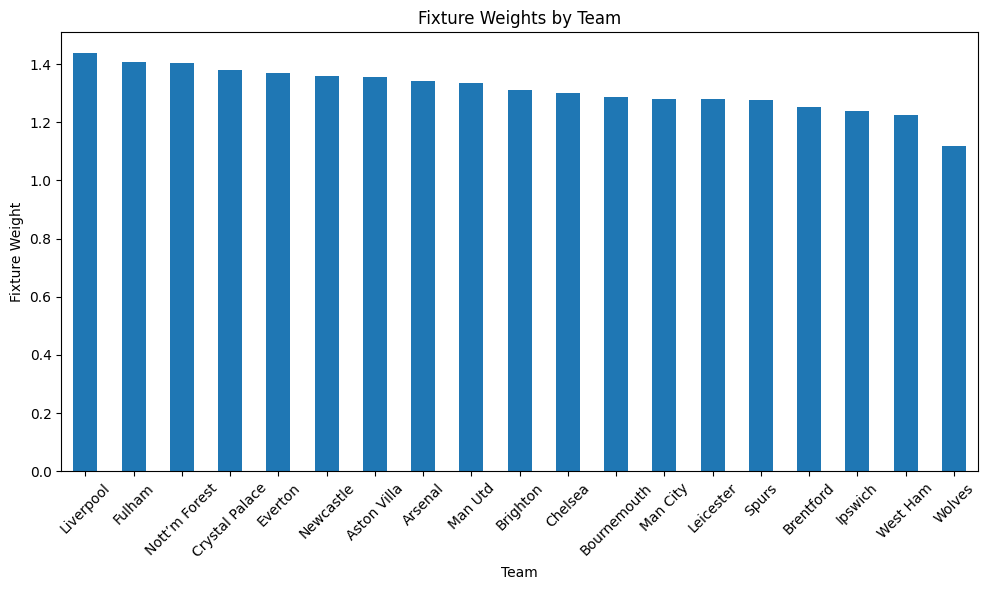

In [48]:
fixture_weights_df = pd.DataFrame.from_dict(fixture_weights, orient='index', columns=['Fixture_Weight'])
fixture_weights_df = fixture_weights_df.sort_values(by='Fixture_Weight', ascending=False)

plt.figure(figsize=(10, 6))
fixture_weights_df['Fixture_Weight'].plot(kind='bar')
plt.title('Fixture Weights by Team')
plt.xlabel('Team')
plt.ylabel('Fixture Weight')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
df.columns

Index(['season', 'name', 'position', 'team', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'team_a_score', 'team_h_score', 'threat',
       'total_points', 'transfers_balance', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'yellow_cards', 'GW', 'selected_by_percent',
       'year', 'new_value', 'played', 'player_id', 'team_code', 'month',
       'day_of_month', 'day_of_week', 'time', 'predicted_total_points',
       'days_ago', 'weight', 'weighted_predicted_points'],
      dtype='object')

In [50]:
assert (df[df['name'] == "Erling Haaland"]['new_value'] == 150).all(), "Assertion failed: Not all 'new_value' entries for Erling Haaland are 150"

In [51]:
assert (df[df['name'] == "Bruno Borges Fernandes"]['new_value'] == 85).all(), "Assertion failed"

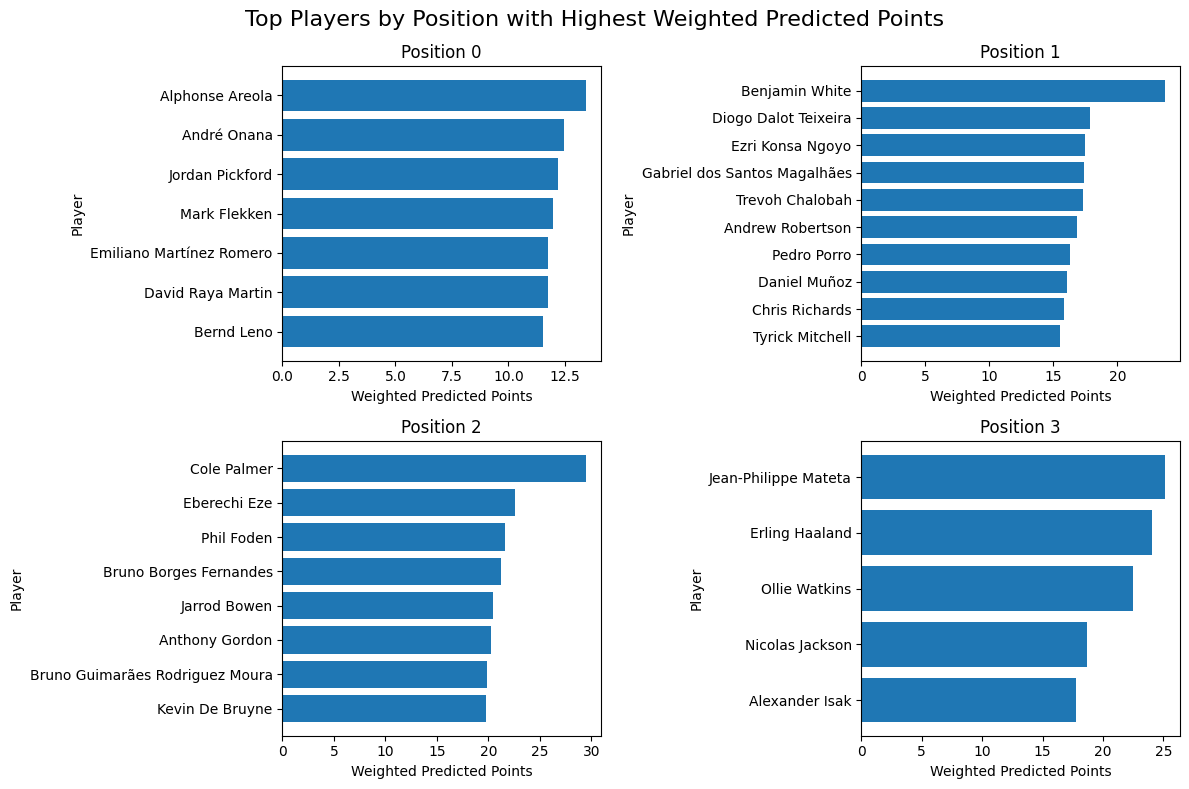

In [52]:
# Create a dictionary to map positions to their index
position_indices = {'0': 0, '1': 1, '2': 2, '3': 3}

# Initialize a figure with subplots for each position
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Top Players by Position with Highest Weighted Predicted Points', fontsize=16)

# Loop through each position and create a subplot
for position, ax in zip(position_indices.keys(), axes.flat):
    # Filter players by position
    position_players = df[df['position'] == position]
    
    # Sort players by 'weighted_predicted_points' in descending order
    position_players_sorted = position_players.sort_values(by='weighted_predicted_points', ascending=False)
    
    # Select the top 10 players
    top_position_players = position_players_sorted.head(10)
    
    # Create a bar plot for the position
    ax.barh(top_position_players['name'], top_position_players['weighted_predicted_points'])
    ax.set_title(f'Position {position}')
    ax.set_xlabel('Weighted Predicted Points')
    ax.set_ylabel('Player')
    ax.invert_yaxis()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# *Optimization Model*

The aim is to maximize the total weighted predicted points of the selected players.

In [53]:
# Initialize the optimization problem
model = LpProblem(name="FPL_Team_Selection", sense=LpMaximize)

# Filter out players from teams not in the fixture difficulty dictionary (since they aren't playing this season)
players = [i for i in df.index if df['team'][i] in fixture_difficulty]

# Variables: Binary variable indicating whether a player is selected or not
player_vars = LpVariable.dicts("Player", players, cat="Binary")

def add_player_constraints(model, players):
    # Objective: Maximize total weighted predicted points
    model += lpSum(df['weighted_predicted_points'][i] * player_vars[i] for i in players)
    
    # Total budget constraints
    model += lpSum(df['new_value'][i] * player_vars[i] for i in players) <= 830
    model += lpSum(df['new_value'][i] * player_vars[i] for i in players) >= 820
    
    # Position constraints
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '0') == 1  # 1 goalkeeper
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '1') >= 3  # min 3 defenders
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '1') <= 5 # max 5 defenders
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '2') >= 2  # min 2 midfielders
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '2') <= 5 # max 5 midfielders
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '3') >= 1  # min 1 forward
    model += lpSum(player_vars[i] for i in players if df['position'][i] == '3') <= 3 # max 3 forwards
    
    # Exactly 11 players must be selected
    model += lpSum(player_vars[i] for i in players) == 11
    
    # Exclude specific players from the team
    if 'players_to_exclude' in globals():
        for player in players:
            if df['name'][player] in players_to_exclude:
                model += player_vars[player] == 0
    
    # No more than 3 players from a single team
    teams = df['team'].unique()
    for team in teams:
        team_players = [i for i in players if df['team'][i] == team]
        model += lpSum(player_vars[i] for i in team_players) <= 3

    # Ensure that only one fixture is selected per player
    unique_players = df['name'].unique()
    for player_name in unique_players:
        player_entries = [i for i in players if df['name'][i] == player_name]
        model += lpSum(player_vars[i] for i in player_entries) <= 1

    # # Force the inclusion of Erling Haaland
    # haaland_index = df.index[df['name'] == 'Erling Haaland'].tolist()
    # if haaland_index:
    #     model += player_vars[haaland_index[0]] == 1  # Force Haaland to be included

# Add all player constraints
add_player_constraints(model, players)

# Solve the optimization problem
solver = PULP_CBC_CMD(timeLimit=600)  # Adding a time limit of 10 minutes for solving
model.solve(solver)

# Get the recommended players
recommended_players = [i for i in players if player_vars[i].varValue == 1]


# destination directory path
destination_path = os.path.join("artifacts")
# Generate the filename with today's date
filename = os.path.join(destination_path, f"predicted_team_{datetime.today().strftime('%Y-%m-%d')}.csv")

# Open the file for writing
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    writer.writerow(["Player", "Position", "Predicted Points", "Value"])
    
    # Write the player details
    for player in recommended_players:
        writer.writerow([
            df['name'][player], 
            df['position'][player], 
            df['weighted_predicted_points'][player], 
            df['new_value'][player]
        ])


# Print the recommended players and their positions
for player in recommended_players:
    print(f"Player: {df['name'][player]}, Position: {df['position'][player]}, Predicted Points: {df['weighted_predicted_points'][player]}, Value: {df['new_value'][player]}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ossianhempel/repos/fpl/.venv/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/7bee7d0a4118461499cfccd74ac2f40e-pulp.mps -max -sec 600 -timeMode elapsed -branch -printingOptions all -solution /var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/7bee7d0a4118461499cfccd74ac2f40e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 223 COLUMNS
At line 193804 RHS
At line 194023 BOUNDS
At line 213518 ENDATA
Problem MODEL has 218 rows, 19494 columns and 135098 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 600
Option for timeMode changed from cpu to elapsed
Continuous objective value is 236.869 - 0.01 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 4 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 4 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tighten

# *Sources*

@misc{anand2016fantasypremierleague, title = {{FPL Historical Dataset}}, author = {Anand, Vaastav}, year = {2022}, howpublished = {Retrieved August 2023 from \url{https://github.com/vaastav/Fantasy-Premier-League/}} }

https://github.com/neelthakurdas/fpl_points_predictor/tree/main